<a href="https://colab.research.google.com/github/forexms78/AI-05-/blob/main/10_03%ED%8C%80_%EB%B0%95%EB%B3%91%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 뉴스 카테고리 분류 프로젝트

**작성자**: 03팀 박병호  

## 📌 프로젝트 목표
20개 카테고리의 뉴스 기사를 자동으로 분류하는 딥러닝 모델 개발

## 🔧 사용 기술 스택
- **데이터**: 20 Newsgroups (18,846개 문서)
- **임베딩**: Word2Vec, FastText, GloVe
- **모델**: Bidirectional LSTM
- **프레임워크**: PyTorch
- **평가 지표**: Accuracy, Precision, Recall, F1-score

## 📊 예상 워크플로우
1. 데이터 로드 및 전처리
2. 세 가지 임베딩 생성
3. LSTM 모델 학습
4. 성능 비교 및 분석

In [1]:
# @title 0.Colab 캐시로인한 한글깨짐 방지

# 1️⃣ 나눔고딕 폰트 설치
!apt -qq -y install fonts-nanum > /dev/null

# 2️⃣ matplotlib 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 3️⃣ 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
mpl.rc('font', family='NanumGothic')  # 전역 폰트 설정
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [2]:
# @title 1.라이브러리 및 임포트 환경 설정

"""
필요한 라이브러리:
- gensim: Word2Vec, FastText 구현
- torch: 딥러닝 프레임워크
- sklearn: 데이터 분할, 평가 지표
- nltk: 텍스트 전처리
"""

!pip install gensim

from gensim.models import Word2Vec, FastText
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
import os
import urllib.request
import zipfile
import pandas as pd

# NLTK 데이터 다운로드
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  사용 디바이스: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 107.3 MB/s eta 0:00:00
🖥️  사용 디바이스: cuda


In [3]:
# @title 2.데이터 로드


"""
20 Newsgroups 데이터셋:
- 18,846개의 뉴스 문서
- 20개 카테고리 (정치, 스포츠, 컴퓨터 등)
- remove 옵션: 헤더, 푸터, 인용문 제거 (순수한 본문만 사용)
"""

print("\n📰 데이터 로딩 중...")
news_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = news_data.data
labels = news_data.target

print(f"✅ 전체 문서 수: {len(texts)}")
print(f"✅ 카테고리 수: {len(set(labels))}")
print(f"\n📋 샘플 텍스트 (처음 200자):\n{texts[0][:200]}...")


📰 데이터 로딩 중...
✅ 전체 문서 수: 18846
✅ 카테고리 수: 20

📋 샘플 텍스트 (처음 200자):


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However,...


> 데이터에서 footer header quotes 를 제거하고 필요한 텍스트만 추출합니다




🧹 데이터 전처리 중...
✅ 훈련 데이터 평균 길이: 92.7 단어
✅ 훈련 데이터 최대 길이: 6315 단어
✅ 훈련 데이터 95분위수: 280.0 단어


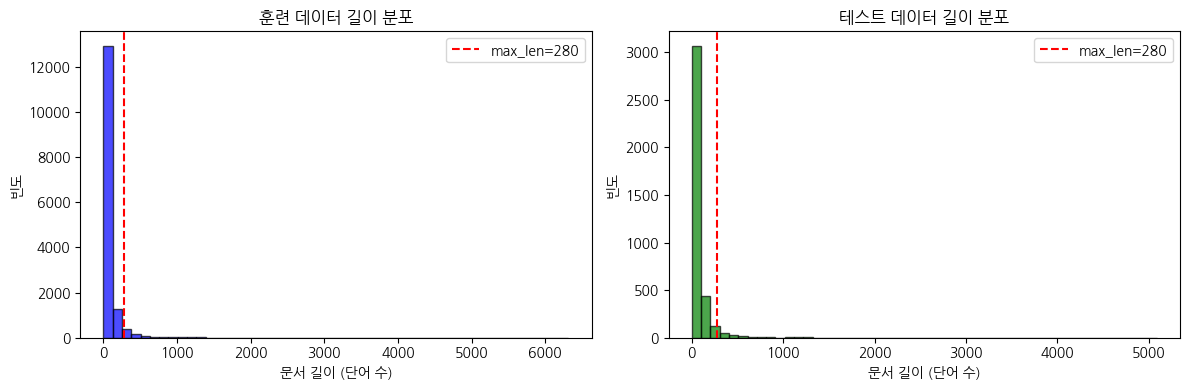

In [4]:
# @title 3.데이터 전처리

# ============================================
# 3. 데이터 전처리
# ============================================
"""
전처리 단계:
1. 소문자 변환: 대소문자 통일
2. 특수문자/숫자 제거: 순수한 텍스트만 남김
3. 불용어 제거: "the", "is", "a" 같은 의미 없는 단어 제거
"""

def clean_text(text):
    """텍스트 정제 함수"""
    text = text.lower()  # 소문자 변환
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 알파벳과 공백만 남김
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  # 2글자 이하 제거
    return ' '.join(tokens)

print("\n🧹 데이터 전처리 중...")

# 데이터 분할 (80% 훈련, 20% 테스트)
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels  # stratify: 클래스 비율 유지
)

# 전처리 적용
train_inputs = [clean_text(text) for text in train_inputs]
test_inputs = [clean_text(text) for text in test_inputs]

# 문장 길이 분석
train_lengths = [len(word_tokenize(msg)) for msg in train_inputs]
test_lengths = [len(word_tokenize(msg)) for msg in test_inputs]

print(f"✅ 훈련 데이터 평균 길이: {np.mean(train_lengths):.1f} 단어")
print(f"✅ 훈련 데이터 최대 길이: {np.max(train_lengths)} 단어")
print(f"✅ 훈련 데이터 95분위수: {np.percentile(train_lengths, 95):.1f} 단어")

# 길이 분포 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('문서 길이 (단어 수)')
plt.ylabel('빈도')
plt.title('훈련 데이터 길이 분포')
plt.axvline(280, color='red', linestyle='--', label='max_len=280')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(test_lengths, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('문서 길이 (단어 수)')
plt.ylabel('빈도')
plt.title('테스트 데이터 길이 분포')
plt.axvline(280, color='red', linestyle='--', label='max_len=280')
plt.legend()
plt.tight_layout()
plt.show()

# max_len 설정 (95분위수 기준)
max_len = 280

> 텍스트에 소문자변환, 특수문자 제거, 불용어 제거를 진행하고 max_len의 길이를 파악하기위해 토큰화된 문서길이를 확보합니다

In [5]:
# @title 4.토큰화

"""
토큰화: 문장을 단어 리스트로 분리
"I love this" → ["I", "love", "this"]
"""

print("\n✂️  토큰화 진행 중...")
train_sentences = [word_tokenize(text) for text in train_inputs]
test_sentences = [word_tokenize(text) for text in test_inputs]


✂️  토큰화 진행 중...


In [6]:
# @title 5.Word2Vec Embedding

"""
Word2Vec:
- 주변 단어를 보고 단어의 의미를 학습
- vector_size=128: 각 단어를 128차원 벡터로 표현
- window=5: 앞뒤 5개 단어 참고
- sg=1: Skip-gram 방식 (중심 단어로 주변 단어 예측)
"""

print("\n🔤 Word2Vec 학습 중...")
word2vec_model = Word2Vec(
    sentences=train_sentences,
    vector_size=128,
    window=5,
    min_count=1,
    sg=1,
    workers=4
)

# 임베딩 행렬 생성
word2vec_matrix = np.zeros((len(word2vec_model.wv) + 1, 128))
word2idx_word2vec = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}

for word, idx in word2idx_word2vec.items():
    word2vec_matrix[idx] = word2vec_model.wv[word]

print(f"✅ Word2Vec 어휘 크기: {len(word2idx_word2vec)}")


🔤 Word2Vec 학습 중...
✅ Word2Vec 어휘 크기: 108149


> 보통 sg=1 skip gram은 sg=-

In [7]:
# @title 6.FastText Embedding

"""
FastText:
- Word2Vec의 개선 버전
- 단어를 서브워드(subword)로 분해
- 예: "unhappiness" = "un" + "happy" + "ness"
- 장점: 학습하지 않은 새로운 단어도 어느 정도 이해 가능
"""

print("\n🚀 FastText 학습 중...")
fasttext_model = FastText(
    sentences=train_sentences,
    vector_size=128,
    window=5,
    min_count=1,
    sg=1,
    workers=4
)

fasttext_matrix = np.zeros((len(fasttext_model.wv) + 1, 128))
word2idx_fasttext = {word: idx + 1 for idx, word in enumerate(fasttext_model.wv.index_to_key)}

for word, idx in word2idx_fasttext.items():
    fasttext_matrix[idx] = fasttext_model.wv[word]

print(f"✅ FastText 어휘 크기: {len(word2idx_fasttext)}")


🚀 FastText 학습 중...
✅ FastText 어휘 크기: 108149


In [8]:
# @title 7.GloVe 임베딩


"""
GloVe (Global Vectors):
- 스탠포드에서 미리 학습한 임베딩
- 대규모 말뭉치로 학습됨
- 장점: 일반적인 영어 이해 능력 우수
"""

print("\n🌐 GloVe 임베딩 로드 중...")

GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "glove.6B.zip"
GLOVE_FILE = "glove.6B.200d.txt"

if not os.path.exists(GLOVE_FILE):
    print("📥 GloVe 다운로드 중... (시간이 걸릴 수 있습니다)")
    urllib.request.urlretrieve(GLOVE_URL, GLOVE_ZIP)
    with zipfile.ZipFile(GLOVE_ZIP, 'r') as zip_ref:
        zip_ref.extractall()
    print("✅ GloVe 다운로드 완료")

embedding_dim = 200
glove_embeddings = {}

with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coeffs

word2idx_glove = {word: idx + 1 for idx, word in enumerate(glove_embeddings.keys())}
glove_matrix = np.zeros((len(word2idx_glove) + 1, embedding_dim))

for word, idx in word2idx_glove.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        glove_matrix[idx] = embedding_vector

print(f"✅ GloVe 어휘 크기: {len(word2idx_glove)}")



🌐 GloVe 임베딩 로드 중...
📥 GloVe 다운로드 중... (시간이 걸릴 수 있습니다)
✅ GloVe 다운로드 완료
✅ GloVe 어휘 크기: 400000


In [9]:
# @title 8.Dataset 클래스 정의

"""
Dataset:
- PyTorch에 데이터를 공급하는 클래스
- 역할: 텍스트 → 숫자 시퀀스 변환 + 패딩
"""

class TextEmbeddingDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_len):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = word_tokenize(self.texts[idx])
        # 단어 → 숫자 변환 (OOV는 0)
        encoded = [self.word2idx.get(word, 0) for word in tokens]

        # 패딩 또는 자르기
        if len(encoded) < self.max_len:
            encoded += [0] * (self.max_len - len(encoded))
        else:
            encoded = encoded[:self.max_len]

        return torch.tensor(encoded, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Dataset 생성
train_dataset_word2vec = TextEmbeddingDataset(train_inputs, train_targets, word2idx_word2vec, max_len)
test_dataset_word2vec = TextEmbeddingDataset(test_inputs, test_targets, word2idx_word2vec, max_len)

train_dataset_fasttext = TextEmbeddingDataset(train_inputs, train_targets, word2idx_fasttext, max_len)
test_dataset_fasttext = TextEmbeddingDataset(test_inputs, test_targets, word2idx_fasttext, max_len)

train_dataset_glove = TextEmbeddingDataset(train_inputs, train_targets, word2idx_glove, max_len)
test_dataset_glove = TextEmbeddingDataset(test_inputs, test_targets, word2idx_glove, max_len)

# DataLoader 생성
train_loader_word2vec = DataLoader(train_dataset_word2vec, batch_size=64, shuffle=True)
test_loader_word2vec = DataLoader(test_dataset_word2vec, batch_size=64, shuffle=False)

train_loader_fasttext = DataLoader(train_dataset_fasttext, batch_size=64, shuffle=True)
test_loader_fasttext = DataLoader(test_dataset_fasttext, batch_size=64, shuffle=False)

train_loader_glove = DataLoader(train_dataset_glove, batch_size=64, shuffle=True)
test_loader_glove = DataLoader(test_dataset_glove, batch_size=64, shuffle=False)




In [10]:
# @title 9.모델정의

"""
EmbeddingLSTM:
1. Embedding Layer: 단어 번호 → 벡터
2. Bidirectional LSTM: 문맥 이해 (앞→뒤, 뒤→앞)
3. Fully Connected Layer: 분류

왜 Bidirectional?
- "not good"에서 "not"이 뒤에 영향을 줌
- "good not"에서 "not"이 앞에 영향을 줌
- 양방향으로 보면 더 정확함
"""

class EmbeddingLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(EmbeddingLSTM, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape

        # 임베딩 레이어 (사전 학습된 임베딩 사용)
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float).to(device),
            freeze=False  # 학습 중 임베딩도 업데이트
        )

        # 양방향 LSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # 완전연결층 (bidirectional이므로 hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        lstm_out, (hidden, _) = self.lstm(embedded)

        # 양방향 LSTM의 마지막 hidden state 결합
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden = self.dropout(hidden)
        output = self.fc(hidden)

        return output

In [11]:
# @title 10.학습 및 평가 함수

def train(model, loader, criterion, optimizer):
    """모델 학습"""
    model.train()
    total_loss = 0
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    """모델 평가 (정확도만)"""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

def evaluate_detailed(model, loader):
    """상세 평가 (Precision, Recall, F1)"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            predictions = torch.argmax(outputs, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels


In [12]:
# @title 11.Word2Vec 모델 학습

print("\n" + "="*50)
print("🔤 Word2Vec + LSTM 학습 시작")
print("="*50)

hidden_dim = 128
output_dim = len(set(labels))

model_word2vec = EmbeddingLSTM(word2vec_matrix, hidden_dim, output_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_word2vec.parameters(), lr=0.001)

train_losses_w2v = []
for epoch in range(10):
    loss = train(model_word2vec, train_loader_word2vec, loss_fn, optimizer)
    train_losses_w2v.append(loss)
    accuracy = evaluate(model_word2vec, test_loader_word2vec)
    print(f"Epoch {epoch+1:2d} | Loss: {loss:.4f} | Test Accuracy: {accuracy:.4f}")

# 상세 평가
preds_w2v, labels_w2v = evaluate_detailed(model_word2vec, test_loader_word2vec)
print("\n📊 Word2Vec 상세 평가:")
print(classification_report(labels_w2v, preds_w2v, target_names=news_data.target_names, digits=4))



🔤 Word2Vec + LSTM 학습 시작
Epoch  1 | Loss: 2.3463 | Test Accuracy: 0.3456
Epoch  2 | Loss: 1.7421 | Test Accuracy: 0.4369
Epoch  3 | Loss: 1.3637 | Test Accuracy: 0.5095
Epoch  4 | Loss: 1.0861 | Test Accuracy: 0.5719
Epoch  5 | Loss: 0.9239 | Test Accuracy: 0.5724
Epoch  6 | Loss: 0.6482 | Test Accuracy: 0.6024
Epoch  7 | Loss: 0.4965 | Test Accuracy: 0.5822
Epoch  8 | Loss: 0.3823 | Test Accuracy: 0.6088
Epoch  9 | Loss: 0.2941 | Test Accuracy: 0.6249
Epoch 10 | Loss: 0.2713 | Test Accuracy: 0.6156

📊 Word2Vec 상세 평가:
                          precision    recall  f1-score   support

             alt.atheism     0.5481    0.3563    0.4318       160
           comp.graphics     0.5667    0.6103    0.5877       195
 comp.os.ms-windows.misc     0.7850    0.4264    0.5526       197
comp.sys.ibm.pc.hardware     0.5487    0.5459    0.5473       196
   comp.sys.mac.hardware     0.4723    0.6632    0.5517       193
          comp.windows.x     0.8961    0.6970    0.7841       198
            m

In [13]:
# @title 12.FastText 모델 학습

print("\n" + "="*50)
print("🚀 FastText + LSTM 학습 시작")
print("="*50)

model_fasttext = EmbeddingLSTM(fasttext_matrix, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model_fasttext.parameters(), lr=0.001)

train_losses_ft = []
for epoch in range(10):
    loss = train(model_fasttext, train_loader_fasttext, loss_fn, optimizer)
    train_losses_ft.append(loss)
    accuracy = evaluate(model_fasttext, test_loader_fasttext)
    print(f"Epoch {epoch+1:2d} | Loss: {loss:.4f} | Test Accuracy: {accuracy:.4f}")

preds_ft, labels_ft = evaluate_detailed(model_fasttext, test_loader_fasttext)
print("\n📊 FastText 상세 평가:")
print(classification_report(labels_ft, preds_ft, target_names=news_data.target_names, digits=4))



🚀 FastText + LSTM 학습 시작
Epoch  1 | Loss: 2.3153 | Test Accuracy: 0.3305
Epoch  2 | Loss: 1.7771 | Test Accuracy: 0.3820
Epoch  3 | Loss: 1.4404 | Test Accuracy: 0.5008
Epoch  4 | Loss: 1.1707 | Test Accuracy: 0.5424
Epoch  5 | Loss: 0.9403 | Test Accuracy: 0.5952
Epoch  6 | Loss: 0.7429 | Test Accuracy: 0.5854
Epoch  7 | Loss: 0.6019 | Test Accuracy: 0.6156
Epoch  8 | Loss: 0.4804 | Test Accuracy: 0.6430
Epoch  9 | Loss: 0.3782 | Test Accuracy: 0.6347
Epoch 10 | Loss: 0.3424 | Test Accuracy: 0.6403

📊 FastText 상세 평가:
                          precision    recall  f1-score   support

             alt.atheism     0.4802    0.5312    0.5045       160
           comp.graphics     0.7261    0.5846    0.6477       195
 comp.os.ms-windows.misc     0.6117    0.5838    0.5974       197
comp.sys.ibm.pc.hardware     0.5209    0.6990    0.5969       196
   comp.sys.mac.hardware     0.6568    0.5751    0.6133       193
          comp.windows.x     0.8205    0.8081    0.8142       198
            m

In [15]:
# @title 13.GloVe 모델 학습

print("\n" + "="*50)
print("🌐 GloVe + LSTM 학습 시작")
print("="*50)

model_glove = EmbeddingLSTM(glove_matrix, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model_glove.parameters(), lr=0.001)

train_losses_glove = []
for epoch in range(10):
    loss = train(model_glove, train_loader_glove, loss_fn, optimizer)
    train_losses_glove.append(loss)
    accuracy = evaluate(model_glove, test_loader_glove)
    print(f"Epoch {epoch+1:2d} | Loss: {loss:.4f} | Test Accuracy: {accuracy:.4f}")

preds_glove, labels_glove = evaluate_detailed(model_glove, test_loader_glove)
print("\n📊 GloVe 상세 평가:")
print(classification_report(labels_glove, preds_glove, target_names=news_data.target_names, digits=4))



🌐 GloVe + LSTM 학습 시작
Epoch  1 | Loss: 2.2698 | Test Accuracy: 0.3671
Epoch  2 | Loss: 1.5809 | Test Accuracy: 0.5204
Epoch  3 | Loss: 1.2680 | Test Accuracy: 0.5586
Epoch  4 | Loss: 1.0389 | Test Accuracy: 0.5947
Epoch  5 | Loss: 0.8469 | Test Accuracy: 0.6204
Epoch  6 | Loss: 0.7346 | Test Accuracy: 0.6430
Epoch  7 | Loss: 0.5717 | Test Accuracy: 0.6485
Epoch  8 | Loss: 0.4599 | Test Accuracy: 0.6586
Epoch  9 | Loss: 0.3764 | Test Accuracy: 0.6493
Epoch 10 | Loss: 0.3065 | Test Accuracy: 0.6565

📊 GloVe 상세 평가:
                          precision    recall  f1-score   support

             alt.atheism     0.5200    0.4062    0.4561       160
           comp.graphics     0.6400    0.6564    0.6481       195
 comp.os.ms-windows.misc     0.5971    0.6244    0.6104       197
comp.sys.ibm.pc.hardware     0.5021    0.6020    0.5476       196
   comp.sys.mac.hardware     0.6626    0.5596    0.6067       193
          comp.windows.x     0.7939    0.6616    0.7218       198
            misc.fo

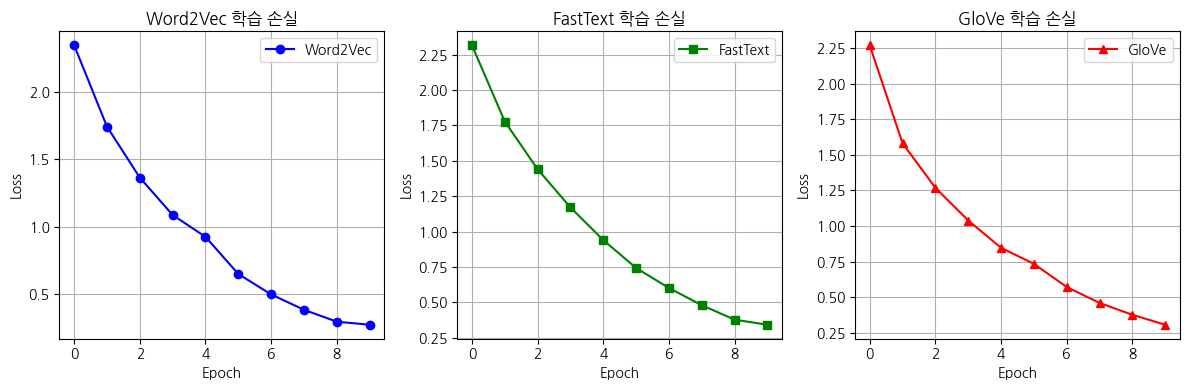


📊 최종 성능 비교
  임베딩 방식  Accuracy  어휘 크기
Word2Vec  0.615650 108149
FastText  0.640318 108149
   GloVe  0.656499 400000

🏆 최고 성능: GloVe


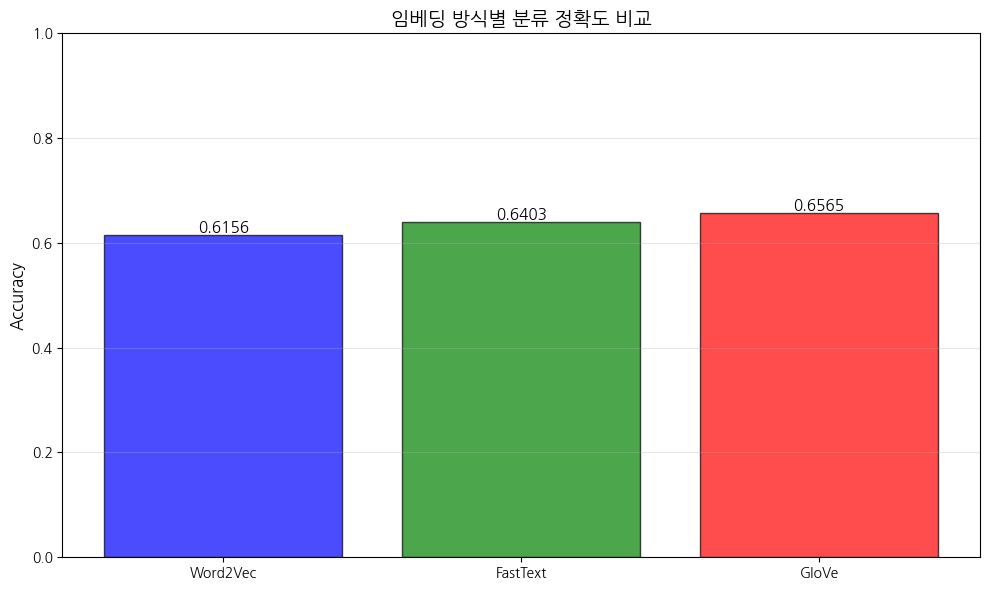

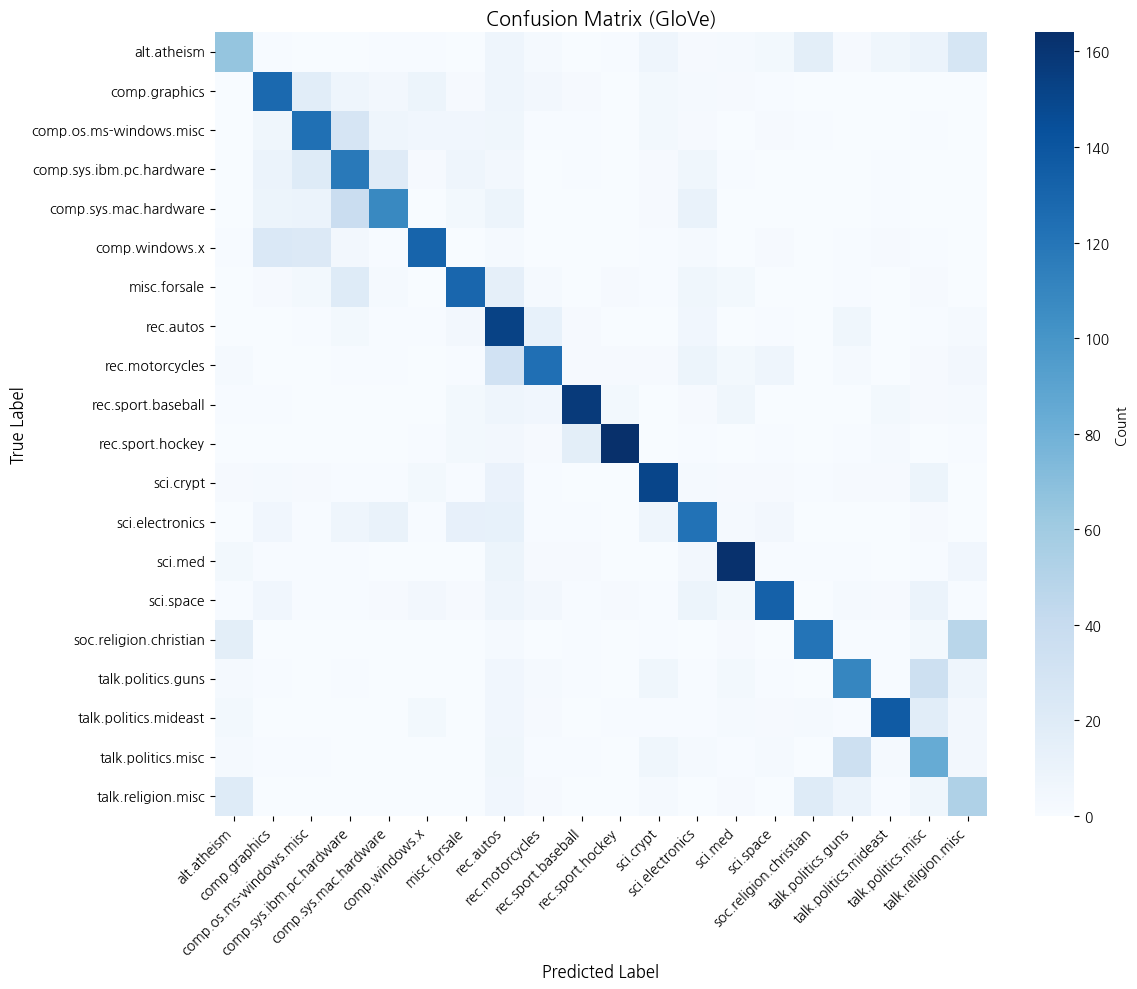


✅ 모든 학습 및 평가 완료!
📌 제출 전 체크리스트:
   ✓ 세 가지 임베딩 모두 구현
   ✓ Precision, Recall, F1-score 계산
   ✓ 성능 비교 시각화
   ✓ 마크다운 설명 추가 (노트북에서)


In [16]:
# @title 14. 성능 비교 시각화

# 14-1. 손실 함수 비교
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses_w2v, marker='o', label='Word2Vec', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Word2Vec 학습 손실')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_losses_ft, marker='s', label='FastText', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FastText 학습 손실')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_losses_glove, marker='^', label='GloVe', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GloVe 학습 손실')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 14-2. 정확도 비교 표
acc_w2v = accuracy_score(labels_w2v, preds_w2v)
acc_ft = accuracy_score(labels_ft, preds_ft)
acc_glove = accuracy_score(labels_glove, preds_glove)

comparison_df = pd.DataFrame({
    '임베딩 방식': ['Word2Vec', 'FastText', 'GloVe'],
    'Accuracy': [acc_w2v, acc_ft, acc_glove],
    '어휘 크기': [len(word2idx_word2vec), len(word2idx_fasttext), len(word2idx_glove)]
})

print("\n" + "="*50)
print("📊 최종 성능 비교")
print("="*50)
print(comparison_df.to_string(index=False))
print("\n🏆 최고 성능:", comparison_df.loc[comparison_df['Accuracy'].idxmax(), '임베딩 방식'])

# 14-3. 성능 비교 막대 그래프
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['임베딩 방식'], comparison_df['Accuracy'],
               color=['blue', 'green', 'red'], alpha=0.7, edgecolor='black')
plt.ylabel('Accuracy', fontsize=12)
plt.title('임베딩 방식별 분류 정확도 비교', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)

# 막대 위에 정확도 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 14-4. Confusion Matrix (GloVe 기준)
plt.figure(figsize=(12, 10))
cm = confusion_matrix(labels_glove, preds_glove)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=news_data.target_names,
            yticklabels=news_data.target_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (GloVe)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n✅ 모든 학습 및 평가 완료!")
print("📌 제출 전 체크리스트:")
print("   ✓ 세 가지 임베딩 모두 구현")
print("   ✓ Precision, Recall, F1-score 계산")
print("   ✓ 성능 비교 시각화")
print("   ✓ 마크다운 설명 추가 (노트북에서)")
